In this notebook, we try to reproduce the results of <i>Figure 3<i> of <i>Yuan, Cao, Zhao & Wu. (2017). Higher-dimension Tensor Completion via Low-rank Tensor Ring Decomposition.</i>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [0]:
# Setup path

import os
import sys

# From jupyter notebook, starting from Tensor-Completion/
'''
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
'''

# From google colab
# Add parent packages to path
sys.path.append("/content/drive/My Drive/Tensor-Completion")
sys.path.append("/content/drive/My Drive/Tensor-Completion/Code")

# Add lib directory, containing the required libraries, to path
sys.path.append("/content/drive/My Drive/lib")

In [0]:
try:
  import cupy as cp
except:
  pass

import cv2
import matplotlib.pyplot as plt
import numpy as np
import time

from Models.TR_WOPT import TR_WOPT_Model
from metrics import RSE
from Utils import mask_img, TR_fold, TR_unfold

img shape:  (256, 256, 3)


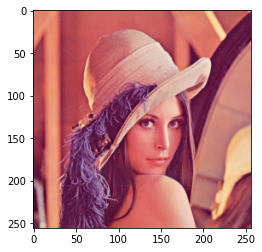

In [4]:
# Read lena image
img_path = '/content/drive/My Drive/Tensor-Completion/Code/data/lena_red.bmp'
img = cv2.imread(img_path, 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256)) / 255
plt.imshow(img)
print("img shape: ", img.shape)

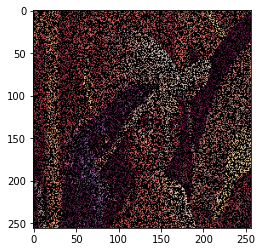

In [5]:
# Mask image

#Transform to cupy array
img = cp.asarray(img)

missing_rate=0.7
img_missing = mask_img(img, missing_rate=missing_rate)
plt.imshow(np.nan_to_num(cp.asnumpy(img_missing)))

In [9]:
# Create and train using gradient descent
ranks = [12]* 4
model = TR_WOPT_Model(img_missing, ranks, lr=1e-6, optimization="ncg")
start = time.time()
model.train(10000)
end = time.time()

print("time: ", end-start)
print("normalized loss: ", model.train_logs)

         Current function value: 6.793156
         Iterations: 10000
         Function evaluations: 18905
         Gradient evaluations: 18905
time:  155.29485297203064
normalized loss:  0.00011517141516065165


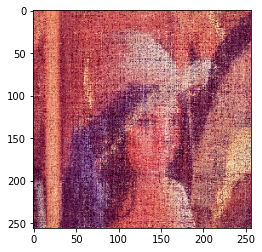

In [10]:
# Reconstruct the image using the trained model

prediction = model.predict()
prediction = np.clip(prediction, 0, 1)
plt.imshow(cp.asnumpy(prediction))

In [11]:
# Compute the RSE of our prediction

error = RSE(img, prediction)
print("RSE:", error)

RSE: 0.2577287468401178


In [0]:
# Reshape the image in 5D and 9D

img_17D = img_missing.reshape([2]*16 + [3])
img_9D = np.moveaxis(img_17D, [0, 8, 1, 9, 2, 10, 3, 11, 4, 12, 5, 13, 6, 14, 7, 15, 16], range(17))\
    .reshape([4]*8 + [3])
img_5D = np.moveaxis(img_missing.reshape([4]*8 + [3]), [0, 4, 1, 5, 2, 6, 3, 7, 8], range(9))\
    .reshape([16]*4 + [3])

In [0]:
# Train each models and compute their prediction

ranks = [12, 24, 36, 48]
imgs = [img_missing, img_5D, img_9D]
dims = [3, 5, 9]

predictions = {}

for img, n_dims in zip(imgs, dims):
    for rank in ranks:
        tr_ranks = [rank]*(n_dims + 1)
        
        model = TR_WOPT_Model(img, tr_ranks, optimization="ncg")
        model.train(5000)
        
        prediction = model.predict()
        prediction = np.clip(prediction, 0, 255)
        
        predictions[f"n_dims_{n_dims}_rank_{rank}"] = prediction

58983

In [0]:
# Compute the RSE for each predictions

for img, n_dims in zip(imgs, dims):
    for rank in ranks:
        